In [1]:
from datetime import datetime
import tensorflow as tf
import importlib
import numpy as np



In [2]:
# import config 
import configs.config
importlib.reload(configs.config)
from configs.config import CFG
from utils import config
config = config.Config.from_json(CFG)

In [3]:
# create Train Series and Dataset 
import dataloader.dataloader
importlib.reload(dataloader.dataloader)
from dataloader.dataloader import Series,Dataset
try: 
    del series,ds
except:
    pass

series = Series(config.data,config.paths)
series.createSeries()
ds = Dataset(series)
ds.split_dataset()

X_train = ds.X_train
y_train = ds.y_train
X_test = ds.X_test
y_test = ds.y_test

X_train.shape

(8339, 128, 2)

In [ ]:
import dataloader.dataloader
importlib.reload(dataloader.dataloader)
from dataloader.dataloader import Test_Series
try: 
    del test_series
except:
    pass
test_series = Test_Series(config.data,config.paths)
test_series.createSeries()

In [36]:
from model.model1D import Unet,Unet_Model
import model.model1D
importlib.reload(model.model1D)
try: 
    del unet
except:
    pass

unet = Unet(n_classes=3,n_filters=8)
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
unet.model((128,2)).summary()

5
4
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 2)]     0           []                               
                                                                                                  
 downsampling_block_5 (Downsamp  ((None, 64, 8),     256         ['input_2[0][0]']                
 lingBlock)                      (None, 128, 8))                                                  
                                                                                                  
 downsampling_block_6 (Downsamp  ((None, 32, 16),    1184        ['downsampling_block_5[0][0]']   
 lingBlock)                      (None, 64, 16))                                                  
                                                                                        

In [40]:
#train model
history = unet.fit(X_train,y_train,epochs = 100)


# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "model/weights/cp-{epoch:04d}.ckpt"
# save weights 
unet.save_weights(checkpoint_path.format(epoch=100))
#save model
models_path = "model/saved_models/unet_{version}_{now}"
unet.save(models_path.format(version = "v1", now = str(datetime.now().date())))

Epoch 1/100
5
4
5
4
261/261 [==============================] - 10s 17ms/step - loss: 1.1521 - accuracy: 0.6422
Epoch 2/100
261/261 [==============================] - 4s 17ms/step - loss: 0.8282 - accuracy: 0.7856
Epoch 3/100
261/261 [==============================] - 4s 16ms/step - loss: 0.6394 - accuracy: 0.8456
Epoch 4/100
261/261 [==============================] - 4s 17ms/step - loss: 0.6154 - accuracy: 0.8516
Epoch 5/100
261/261 [==============================] - 4s 17ms/step - loss: 0.5931 - accuracy: 0.8569
Epoch 6/100
261/261 [==============================] - 5s 20ms/step - loss: 0.5818 - accuracy: 0.8599
Epoch 7/100
261/261 [==============================] - 5s 19ms/step - loss: 0.5706 - accuracy: 0.8614
Epoch 8/100
261/261 [==============================] - 5s 20ms/step - loss: 0.5488 - accuracy: 0.8636
Epoch 9/100
261/261 [==============================] - 5s 18ms/step - loss: 0.3239 - accuracy: 0.8648
Epoch 10/100
261/261 [==============================] - 5s 18ms/step - lo

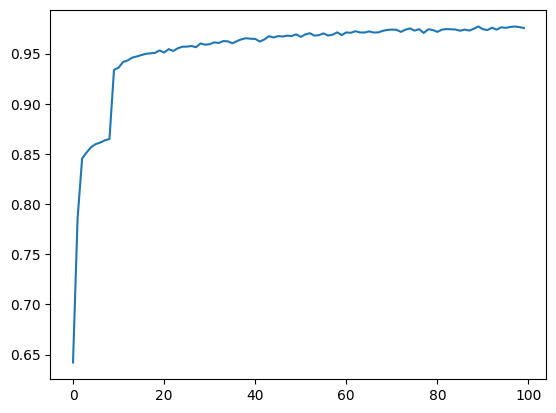

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"])

In [18]:
def accuracy(real,pred):
    comp = real == pred
    return np.sum(comp)/(comp.shape[0]*comp.shape[1])


y_train_pred = unet.predict(X_train)
print("train accuracy : " + str(accuracy(y_train,y_train_pred)))


y_test_pred = unet.predict(X_test)
print("test accuracy : " +  str(accuracy(y_test,y_test_pred)))

In [42]:



def predict(model,test_serie,dataset):

    X = test_serie.get_example()
    X = dataset._transform(X)
    mean = np.zeros(shape =(X.shape))
    length = X.shape[0]
    mod_length = 0 
    i = 0
    while(True):
        if length - 2**(i+1) > 0:    
            i+=1
        else:
            mod_length = 2**i
            break

    rest = length - mod_length
    mean =0
    for i in range(2):
        if i == 0:
            x_pred = X[0:mod_length]
            pred = model.predict(x_pred)    
            mean[0:mod_length] = mean[0:mod_length] + pred
        else:
            x_pred = X[i*rest:]
            pred = model.predict(x_pred)
            mean[i*rest:] = mean[i*rest:] + pred
        
        mean = mean/2
        mean = np.expand_dims(mean,axis =0)

    events = np.argmax(mean,axis = -1,keepdims=True)
    score = np.max(mean,axis=-1,keepdims=True)        
    return (events,score)


test_series_pred = {}
for serie_id, test_serie in test_series.series.items():
    test_series_pred[serie_id] = predict(unet,test_serie,ds)

5
4
1/1 [==============================] - 0s 495ms/step
[[[21.552942  26.69378    0.         0.         0.       ]
  [24.930418  31.017765   0.         0.         0.       ]
  [28.91774   36.122498   0.         0.         0.       ]
  [27.290915  34.172905   0.         0.         0.       ]
  [30.104456  37.641785   0.         0.         0.       ]
  [32.090317  40.184162   0.         0.         0.       ]
  [30.943892  38.716465   0.         0.         0.       ]
  [29.306244  36.61988    0.         0.         0.       ]
  [32.37419   40.547592   0.         0.         0.       ]
  [34.197414  42.881763   0.         0.         0.       ]
  [35.296124  44.288372   0.         0.         0.       ]
  [34.02022   42.65491    0.         0.         0.       ]
  [37.492313  47.10003    0.         0.         0.       ]
  [39.098515  49.156353   0.         0.         0.       ]
  [39.97281   50.27566    0.         0.         0.       ]
  [37.24686   46.78579    0.         0.         0.       ]

In [167]:
from IPython.display import FileLink
import pandas as pd

# import os
# os.chdir(r'kaggle/working')'
filename = 'train_' +'.csv'
pd.DataFrame(test_mask).to_csv(filename)

FileLink(filename)



ValueError: Must pass 2-d input. shape=(51, 8640, 3)